In [ ]:
# !pip install torch torchvision transformers pillow numpy opencv-python pytesseract tqdm matplotlib seaborn scikit-learn
!pip install pytesseract
!apt-get install -y tesseract-ocr

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import LayoutLMv3Model, LayoutLMv3Config, LayoutLMv3Processor
import os
import numpy as np
import cv2
import pytesseract
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import ResNet50_Weights
import threading

pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

In [4]:
class TimeoutError(Exception):
    pass

def run_with_timeout(func, *args, timeout_duration=10, **kwargs):
    result = [None]
    exception = [None]

    def worker():
        try:
            result[0] = func(*args, **kwargs)
        except Exception as e:
            exception[0] = e

    thread = threading.Thread(target=worker)
    thread.daemon = True
    thread.start()
    thread.join(timeout_duration)

    if thread.is_alive():
        return {"text": [""], "left": [0], "top": [0], "width": [0], "height": [0]}
    if exception[0]:
        raise exception[0]
    return result[0]

# Image preprocessing functions

def resize_for_ocr(image_np):
    h, w = image_np.shape[:2]
    if max(h, w) > 800:
        scale = 800 / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        return cv2.resize(image_np, (new_w, new_h))
    return image_np

def preprocess_for_ocr(image_np):
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    processed = cv2.GaussianBlur(thresh, (3, 3), 0)
    return processed

# Function to process a single image for OCR
def process_single_image(img_path, class_idx):
    try:
        # Original function code moved into _process_image_internal
        result = run_with_timeout(_process_single_image_internal, img_path, class_idx, timeout_duration=15)
        return result
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return {
            "img_path": img_path,
            "class_idx": class_idx,
            "words": [],
            "boxes": [],
            "success": False,
            "error": str(e)
        }

def _process_single_image_internal(img_path, class_idx):
    try:
        image = Image.open(img_path).convert("RGB")
        image_np = np.array(image)

        # Preprocess image for OCR
        resized = resize_for_ocr(image_np)
        processed = preprocess_for_ocr(resized)

        # Fast OCR with configuration
        ocr_config = '--oem 1 --psm 3'  # Fast engine mode, auto page segmentation, English language
        ocr_result = pytesseract.image_to_data(processed, output_type=pytesseract.Output.DICT, config=ocr_config)

        # Extract text and boxes
        words = []
        boxes = []
        for i in range(len(ocr_result["text"])):
            word = ocr_result["text"][i]
            if word.strip():
                words.append(word)
                x = ocr_result["left"][i]
                y = ocr_result["top"][i]
                w = ocr_result["width"][i]
                h = ocr_result["height"][i]
                boxes.append([x, y, x + w, y + h])

        return {
            "img_path": img_path,
            "class_idx": class_idx,
            "words": words,
            "boxes": boxes,
            "success": True
        }
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return {
            "img_path": img_path,
            "class_idx": class_idx,
            "words": [],
            "boxes": [],
            "success": False,
            "error": str(e)
        }

# Preprocess the entire dataset for OCR
def preprocess_dataset(root_dir):
    samples = []

    class_map = {
        'fraud1_copy_and_move': 0,
        'fraud2_face_morphing': 1,
        'fraud3_face_replacement': 2,
        'fraud4_combined': 3,
        'positive': 4
    }

    # Collect all image paths and their class indices
    for class_folder, class_idx in class_map.items():
        class_path = os.path.join(root_dir, class_folder)
        if os.path.exists(class_path):
            for img_file in os.listdir(class_path):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    samples.append((os.path.join(class_path, img_file), class_idx))

    print(f"Pre-processing OCR for {len(samples)} images...")
    results = []

    for img_path, class_idx in tqdm(samples, desc="Processing OCR"):
        result = process_single_image(img_path, class_idx)
        results.append(result)

    # Print statistics
    success_count = sum(1 for r in results if r["success"])
    print(f"Successfully processed {success_count}/{len(results)} images")

    return results


In [5]:
# Custom dataset that uses pre-processed OCR results
class DocumentForgeryDataset(Dataset):
    def __init__(self, processed_results, processor, transform=None):
        self.processed_results = [r for r in processed_results if r["success"]]
        self.processor = processor
        self.transform = transform

        self.idx_to_class = {
            0: 'fraud1_copy_and_move',
            1: 'fraud2_face_morphing',
            2: 'fraud3_face_replacement',
            3: 'fraud4_combined',
            4: 'positive'
        }

    def __len__(self):
        return len(self.processed_results)

    def __getitem__(self, idx):
        result = self.processed_results[idx]

        try:
            # Load image
            image = Image.open(result["img_path"]).convert("RGB")

            # Apply ResNet transforms
            if self.transform:
                image_for_resnet = self.transform(image)
            else:
                image_for_resnet = transforms.ToTensor()(image)

            # Use pre-processed OCR results
            encoding = self.processor(
                image,
                result["words"],
                boxes=result["boxes"],
                return_tensors="pt",
                truncation=True,
                padding="max_length",
                max_length=512
            )

            # Remove batch dimension
            for k, v in encoding.items():
                if isinstance(v, torch.Tensor):
                    encoding[k] = v.squeeze(0)

            return {
                "image_for_resnet": image_for_resnet,
                "layoutlm_inputs": encoding,
                "label": torch.tensor(result["class_idx"], dtype=torch.long)
            }
        except Exception as e:
            print(f"Error loading {result['img_path']}: {e}")
            # Return a placeholder with the correct label
            dummy_image = torch.zeros((3, 224, 224))
            dummy_encoding = {
                "input_ids": torch.zeros(512, dtype=torch.long),
                "attention_mask": torch.zeros(512, dtype=torch.long),
                "bbox": torch.zeros((512, 4), dtype=torch.long),
                "pixel_values": torch.zeros((3, 224, 224))
            }
            return {
                "image_for_resnet": dummy_image,
                "layoutlm_inputs": dummy_encoding,
                "label": torch.tensor(result["class_idx"], dtype=torch.long)
            }

In [6]:
class DocumentForgeryDetector(nn.Module):
    def __init__(self, num_classes=5):
        super(DocumentForgeryDetector, self).__init__()

        # Load pre-trained ResNet50 with updated API
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Remove the final FC layer
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # Load pre-trained LayoutLMv3
        self.layoutlm_config = LayoutLMv3Config.from_pretrained("microsoft/layoutlmv3-base")
        self.layoutlm = LayoutLMv3Model.from_pretrained("microsoft/layoutlmv3-base")

        # Feature dimensions
        self.resnet_features = 2048
        self.layoutlm_features = self.layoutlm_config.hidden_size

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(self.resnet_features + self.layoutlm_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, image_for_resnet, layoutlm_inputs):
        # Extract ResNet features
        resnet_output = self.resnet(image_for_resnet)
        resnet_output = resnet_output.view(resnet_output.size(0), -1)

        # Extract LayoutLMv3 features
        layoutlm_output = self.layoutlm(**layoutlm_inputs).last_hidden_state[:, 0, :]

        # Concatenate features
        combined_features = torch.cat((resnet_output, layoutlm_output), dim=1)

        # Final classification
        output = self.fusion(combined_features)

        return output

In [7]:
def train_model(model, train_loader, val_loader, num_epochs, device):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch in pbar:
            image_for_resnet = batch["image_for_resnet"].to(device)
            layoutlm_inputs = {k: v.to(device) for k, v in batch["layoutlm_inputs"].items()}
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(image_for_resnet, layoutlm_inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            pbar.set_postfix({'loss': loss.item(), 'acc': 100*correct/total})

        train_loss = train_loss / len(train_loader)
        train_acc = 100.0 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for batch in pbar:
                image_for_resnet = batch["image_for_resnet"].to(device)
                layoutlm_inputs = {k: v.to(device) for k, v in batch["layoutlm_inputs"].items()}
                labels = batch["label"].to(device)
                outputs = model(image_for_resnet, layoutlm_inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Update progress bar
                pbar.set_postfix({'loss': loss.item(), 'acc': 100*correct/total})

        val_loss = val_loss / len(val_loader)
        val_acc = 100.0 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/content/drive/My Drive/best_forgery_detector.pth')
            print("Saved best model checkpoint.")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')

    return model, train_losses, val_losses, train_accs, val_accs

In [ ]:
# # Evaluation function
# def evaluate_model(model, test_loader, device):
#     model = model.to(device)
#     model.eval()

#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for batch in tqdm(test_loader, desc="Evaluating"):
#             image_for_resnet = batch["image_for_resnet"].to(device)
#             layoutlm_inputs = {k: v.to(device) for k, v in batch["layoutlm_inputs"].items()}
#             labels = batch["label"].to(device)
#             outputs = model(image_for_resnet, layoutlm_inputs)

#         _, predicted = outputs.max(1)

#         all_preds.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

#     class_names = {
#         0: 'fraud1_copy_and_move',
#         1: 'fraud2_face_morphing',
#         2: 'fraud3_face_replacement',
#         3: 'fraud4_combined',
#         4: 'positive'
#     }

#     # # Classification report
#     # print("\nClassification Report:")
#     # report = classification_report(all_labels, all_preds, labels=[0, 1, 2, 3, 4], target_names=list(class_names.values()), zero_division=0)
#     # print(report)

#     # Confusion matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=list(class_names.values()),
#                 yticklabels=list(class_names.values()))
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.tight_layout()
#     plt.savefig('confusion_matrix.png')
#     print("Confusion matrix saved to 'confusion_matrix.png'")

#     return all_preds, all_labels

Starting document forgery detection...
Using device: cuda
Using combined ResNet50 + LayoutLMv3 model
Loading LayoutLMv3 processor...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Preprocessing OCR data...
Pre-processing OCR for 500 images...


Processing OCR: 100%|██████████| 500/500 [11:43<00:00,  1.41s/it]


Successfully processed 500/500 images
Dataset split: 400 train, 100 validation
Initializing model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Starting training...


Epoch 1/30 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Epoch 1/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s, loss=5.4, acc=40]


Epoch: 1/30, Train Loss: 1.2444, Train Acc: 37.50%, Val Loss: 5.4206, Val Acc: 40.00%
Saved best model checkpoint.


Epoch 2/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s, loss=1.73, acc=37]


Epoch: 2/30, Train Loss: 1.0063, Train Acc: 47.00%, Val Loss: 1.5572, Val Acc: 37.00%
Saved best model checkpoint.


Epoch 3/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s, loss=45.6, acc=19]


Epoch: 3/30, Train Loss: 1.1352, Train Acc: 42.50%, Val Loss: 27.0195, Val Acc: 19.00%


Epoch 4/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s, loss=1.33, acc=40]


Epoch: 4/30, Train Loss: 1.0166, Train Acc: 50.25%, Val Loss: 1.0067, Val Acc: 40.00%
Saved best model checkpoint.


Epoch 5/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s, loss=2.11, acc=45]


Epoch: 5/30, Train Loss: 0.9823, Train Acc: 50.50%, Val Loss: 1.2710, Val Acc: 45.00%


Epoch 6/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s, loss=0.972, acc=42]


Epoch: 6/30, Train Loss: 0.9738, Train Acc: 52.50%, Val Loss: 1.0669, Val Acc: 42.00%


Epoch 7/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s, loss=1.2, acc=44]


Epoch: 7/30, Train Loss: 0.8782, Train Acc: 49.75%, Val Loss: 1.1741, Val Acc: 44.00%


Epoch 8/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s, loss=1.09, acc=41]


Epoch: 8/30, Train Loss: 0.8857, Train Acc: 53.75%, Val Loss: 1.0113, Val Acc: 41.00%


Epoch 9/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s, loss=1.28, acc=41]


Epoch: 9/30, Train Loss: 0.7742, Train Acc: 56.50%, Val Loss: 1.0512, Val Acc: 41.00%


Epoch 10/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s, loss=1.38, acc=46]


Epoch: 10/30, Train Loss: 0.7759, Train Acc: 55.50%, Val Loss: 1.2101, Val Acc: 46.00%


Epoch 11/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s, loss=0.948, acc=52]


Epoch: 11/30, Train Loss: 0.7128, Train Acc: 59.50%, Val Loss: 0.8906, Val Acc: 52.00%
Saved best model checkpoint.


Epoch 12/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s, loss=0.833, acc=46]


Epoch: 12/30, Train Loss: 0.6774, Train Acc: 63.00%, Val Loss: 0.9052, Val Acc: 46.00%


Epoch 13/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s, loss=0.733, acc=52]


Epoch: 13/30, Train Loss: 0.6399, Train Acc: 63.50%, Val Loss: 0.8359, Val Acc: 52.00%
Saved best model checkpoint.


Epoch 14/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s, loss=1.35, acc=50]


Epoch: 14/30, Train Loss: 0.6236, Train Acc: 63.00%, Val Loss: 0.9169, Val Acc: 50.00%


Epoch 15/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s, loss=0.824, acc=48]


Epoch: 15/30, Train Loss: 0.6100, Train Acc: 63.25%, Val Loss: 0.8913, Val Acc: 48.00%


Epoch 16/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s, loss=0.991, acc=55]


Epoch: 16/30, Train Loss: 0.6070, Train Acc: 66.25%, Val Loss: 0.9249, Val Acc: 55.00%


Epoch 17/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s, loss=0.654, acc=56]


Epoch: 17/30, Train Loss: 0.5505, Train Acc: 65.75%, Val Loss: 0.8198, Val Acc: 56.00%
Saved best model checkpoint.


Epoch 18/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s, loss=1.09, acc=44]


Epoch: 18/30, Train Loss: 0.5276, Train Acc: 70.75%, Val Loss: 0.9597, Val Acc: 44.00%


Epoch 19/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s, loss=1.58, acc=46]


Epoch: 19/30, Train Loss: 0.5426, Train Acc: 68.25%, Val Loss: 0.9928, Val Acc: 46.00%


Epoch 20/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s, loss=0.938, acc=54]


Epoch: 20/30, Train Loss: 0.5307, Train Acc: 68.75%, Val Loss: 0.8680, Val Acc: 54.00%


Epoch 21/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, loss=1.2, acc=48]


Epoch: 21/30, Train Loss: 0.5211, Train Acc: 69.50%, Val Loss: 0.9478, Val Acc: 48.00%


Epoch 22/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s, loss=0.67, acc=52]


Epoch: 22/30, Train Loss: 0.5090, Train Acc: 67.75%, Val Loss: 0.8902, Val Acc: 52.00%


Epoch 23/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s, loss=0.61, acc=48]


Epoch: 23/30, Train Loss: 0.5071, Train Acc: 66.25%, Val Loss: 0.8791, Val Acc: 48.00%


Epoch 24/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, loss=0.593, acc=50]


Epoch: 24/30, Train Loss: 0.4894, Train Acc: 69.50%, Val Loss: 0.8787, Val Acc: 50.00%


Epoch 25/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, loss=0.556, acc=49]


Epoch: 25/30, Train Loss: 0.4751, Train Acc: 71.25%, Val Loss: 0.8965, Val Acc: 49.00%


Epoch 26/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s, loss=0.551, acc=48]


Epoch: 26/30, Train Loss: 0.4716, Train Acc: 73.00%, Val Loss: 0.9027, Val Acc: 48.00%


Epoch 27/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s, loss=0.496, acc=51]


Epoch: 27/30, Train Loss: 0.4889, Train Acc: 73.25%, Val Loss: 0.8771, Val Acc: 51.00%


Epoch 28/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s, loss=0.542, acc=49]


Epoch: 28/30, Train Loss: 0.4770, Train Acc: 71.25%, Val Loss: 0.8909, Val Acc: 49.00%


Epoch 29/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s, loss=0.498, acc=51]


Epoch: 29/30, Train Loss: 0.4800, Train Acc: 71.50%, Val Loss: 0.9008, Val Acc: 51.00%


Epoch 30/30 [Val]: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, loss=0.568, acc=50]


Epoch: 30/30, Train Loss: 0.4605, Train Acc: 70.75%, Val Loss: 0.8990, Val Acc: 50.00%
Training completed and model saved!


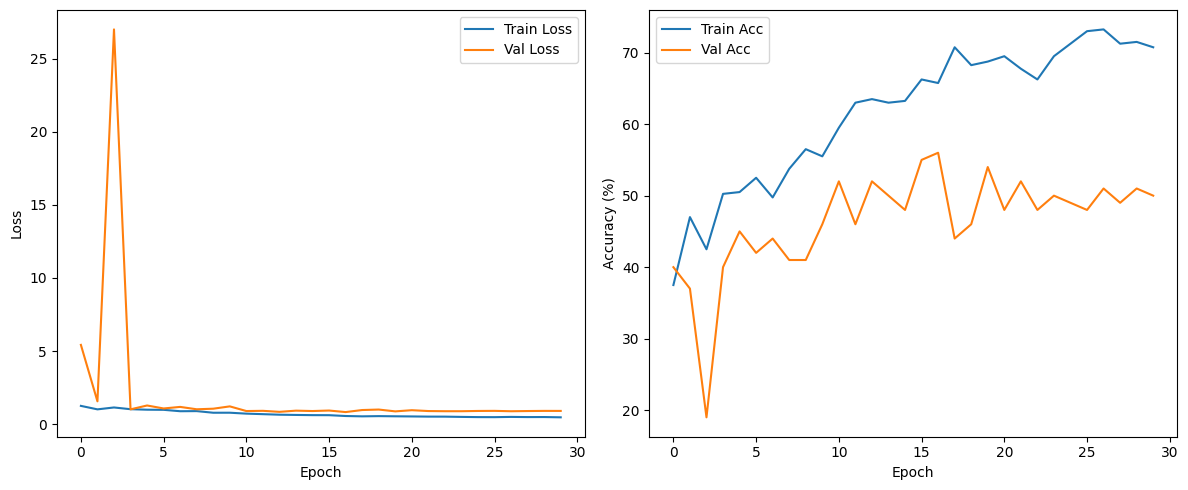

In [ ]:
def main(preprocess_ocr=True):
    print("Starting document forgery detection...")

    # Set up paths and parameters
    data_root = "/content/drive/MyDrive/Document_Forgery_Dataset_Short"
    ocr_cache_path = "/content/drive/MyDrive/cached_ocr_results_small.pth"
    batch_size = 8
    num_epochs = 30

    # Define image transformations for ResNet
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load LayoutLMv3 processor
    print("Loading LayoutLMv3 processor...")
    processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

    # Pre-process OCR
    if preprocess_ocr:
        if os.path.exists(ocr_cache_path):
            print("Loading OCR data from cache...")
            ocr_results = torch.load(ocr_cache_path)
            print("done..")
        else:
            print("Preprocessing OCR data...")
            ocr_results = preprocess_dataset(data_root)
            torch.save(ocr_results, ocr_cache_path)

        dataset = DocumentForgeryDataset(ocr_results, processor, transform)
    else:
        raise ValueError("OCR preprocessing must be enabled for the combined model!")

    # Split dataset
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.2 * total_size)

    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    print(f"Dataset split: {train_size} train, {val_size} validation")

    # Initialize data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print("Initializing model...")
    model = DocumentForgeryDetector(num_classes=5).to(device) 

    print("Starting training...")
    trained_model, train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, num_epochs, device)

    print("Training completed and model saved!")
    return trained_model

if __name__ == "__main__":
    preprocess_ocr = True
    trained_model = main(preprocess_ocr)


In [ ]:
# def main(preprocess_ocr=True):
#     print("Starting document forgery detection...")

#     # Set up paths and parameters
#     data_root = "/content/drive/MyDrive/Document_Forgery_Dataset_Short"
#     ocr_cache_path = "/content/drive/MyDrive/cached_ocr_results_small.pth"
#     batch_size = 8
#     num_epochs = 30

#     # Define image transformations for ResNet
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")

#     # Load LayoutLMv3 processor
#     print("Loading LayoutLMv3 processor...")
#     processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

#     # Pre-process OCR if enabled
#     if preprocess_ocr:
#         if os.path.exists(ocr_cache_path):
#             print("Loading OCR data from cache...")
#             ocr_results = torch.load(ocr_cache_path)
#             print("done..")
#         else:
#             print("Preprocessing OCR data...")
#             ocr_results = preprocess_dataset(data_root)
#             torch.save(ocr_results, ocr_cache_path)

#         # Move this line out of the if-else so it's always executed
#         dataset = DocumentForgeryDataset(ocr_results, processor, transform)
#     else:
#         raise ValueError("OCR preprocessing must be enabled for the combined model!")

#     # Split dataset
#     total_size = len(dataset)
#     train_size = int(0.8 * total_size)
#     val_size = int(0.2 * total_size)
#     # test_size = total_size - train_size - val_size

#     train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
#     print(f"Dataset split: {train_size} train, {val_size} validation")

#     # Initialize data loaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

#     print("Initializing model...")
#     model = DocumentForgeryDetector(num_classes=5).to(device) 

#     # Train model
#     print("Starting training...")
#     trained_model, train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, num_epochs, device)

#     # Evaluate model
#     # print("Evaluating model...")
#     # all_preds, all_labels = evaluate_model(model, test_loader, device)

#     # print("Unique labels in test set:", set(all_labels))
#     # print("Unique predictions:", set(all_preds))

#     print("Training completed and model saved!")
#     return trained_model

# if __name__ == "__main__":
#     preprocess_ocr = True  # Must be True, else raises error
#     trained_model = main(preprocess_ocr)
